In [2]:
import json
import itertools  # itertools.combinations may be useful
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import streamlit as st
# import altair as alt
import pickle
import plotly.graph_objects as go
import plotly.express as px

# can conda install everything except streamlit. do it with pip in the conda env


In [3]:
d_to_idx = {'X': 23, 'Y': 24, 'M': 25}
d_to_idx.update({str(i): i for i in range(1, 23)})

chr_lengths = {'1': 250_000_000,
                '2':   245_000_000,
                '3':   200_000_000,
                '4':   195_000_000,
                '5':   185_000_000,
                '6':   175_000_000,
                '7':   160_000_000,
                '8':   146_000_000,
                '9':   142_000_000,
                '10':  136_000_000,
                '11':  136_000_000,
                '12':  135_000_000,
                '13':  116_000_000,
                '14':  108_000_000,
                '15':  103_000_000,
                '16':  91_000_000,
                '17':  82_000_000,
                '18':  80_000_000,
                '19':  60_000_000,
                '20':  64_000_000,
                '21':  48_000_000,
                '22':  51_000_000,
                'X':   156_000_000,
                'Y':   59_000_000}

domain_starts = []
start = 0
domain_starts.append(start)
for cl in chr_lengths.values():
    start += cl
    domain_starts.append(start)

print(domain_starts)

[0, 250000000, 495000000, 695000000, 890000000, 1075000000, 1250000000, 1410000000, 1556000000, 1698000000, 1834000000, 1970000000, 2105000000, 2221000000, 2329000000, 2432000000, 2523000000, 2605000000, 2685000000, 2745000000, 2809000000, 2857000000, 2908000000, 3064000000, 3123000000]


In [4]:
def load_json(input):
    # Opening JSON file
    f = open(input)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    # Closing file
    f.close() 
    return data

In [5]:
# OBSOLETE
def get_cn(key,input):
    data = load_json(input)
    for i,el in enumerate(data["intervals"]):
        if el['iid']==key:
            return el['y']
        else:
            continue

    return 0

In [6]:
def draw_network(G):
    # Set overall figure size
    fig = plt.figure(figsize=(20,20))
    fig.tight_layout()

    nx.draw_networkx(G)

In [7]:
def draw_network_colors(G,jsonfile):
    input = jsonfile
    node_list = list(G.nodes())
    cn = []
    for node in node_list:
        cn.append(get_cn(node,input))

    #nx.set_node_attributes(G, cn, 'cn')

    fig = plt.figure(figsize=(70,10))
    ax = fig.add_subplot(111)

    #cmap = plt.cm.get_cmap('rainbow')
    cmap = plt.cm.coolwarm
    vmin = 0
    vmax = max(cn) #if len(cn)>0 else 0
    # nx.draw(G, pos=nx.spring_layout(G), node_color = cn, vmin=vmin, vmax=vmax, cmap=cmap,with_labels=True)

    positions=nx.get_node_attributes(G,'pos')
    domains=nx.get_node_attributes(G,'domain')

    # d_starts = [0, 140_000_000]
    final_positions = {}

    for pos, dom in zip(positions.items(), domains.items()):
        label, (x, y) = pos
        _, d = dom

        idx_dom = int(d_to_idx[d])


        final_positions[label] = [x + domain_starts[idx_dom-1], y]

    xmax = max([v[0] for k,v in positions.items()])
    
    nx.draw_networkx(G, final_positions, node_shape="s", node_color = cn, node_size=100, font_size=8,
            vmin=vmin, vmax=vmax, cmap=cmap, with_labels=True,
            ax=ax)
    

    # Works properly if domain_starts values are modulo of the tick range step (here 10M)
    max_xlim = int(ax.get_xlim()[1])
    tick_range = range(0, max_xlim, 10_000_000)
    labels = [f"{(i % domain_starts[1]) / 1e6  :.0f}M" for i in tick_range]

    ax.set_xlim(0, max_xlim)
    ax.set_xticks(tick_range, labels , rotation=-45)
    ax.tick_params(bottom=True, labelbottom=True)

    for ypos in domain_starts:
        ax.axvline(ypos, c="k")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm,fraction=0.046, pad=0.04, aspect=10) # https://matplotlib.org/stable/api/colorbar_api.html

    ax.tick_params(left=True, right=True, top=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title("The Longest Chain")
    ax.set_ylabel("Copy Number")
    ax.set_xlabel("Starting Position/$10^{9}$")
    #ax.set_xlim(0,xmax*1.01)
    #ax.set_xscale("log")
  

In [48]:
def check_oncone_coverage(df):

    # check if a node overlaps with the following oncongenes

    # oncognes = {'oncogene': [chromosome number, start point, end point],...}
    oncogenes = {'EGFR': ['7', 55019017,55211628],
                'c-MYC': ['8', 127735434,127742951],
                'ERBB2': ['17', 39688094,39728658],
                'KRAS' : ['12', 25205246,25250929],
                'MDM2/CDK4': ['12', 57747727,57752310]}
    
    onco_node = {}
    
    for key,value in oncogenes.items():
        print(key,"Chr:",value[0])
        print(df[
            (df['Chromosome']==value[0]) & (
            ((df['Start_Point']<value[1]) & (df['End_Point']>value[1])) | 
            ((df['Start_Point']<value[2]) & (df['End_Point']>value[2])) |
            ((df['Start_Point']>value[1]) & (df['End_Point']<value[2])) |
            ((df['Start_Point']<value[1]) & (df['End_Point']>value[2]))
            )
            ][['Source','Copy_Number','Start_Point','End_Point']]   )
        
        onco_node[key] = df[
            (df['Chromosome']==value[0]) & (
            ((df['Start_Point']<value[1]) & (df['End_Point']>value[1])) | 
            ((df['Start_Point']<value[2]) & (df['End_Point']>value[2])) |
            ((df['Start_Point']>value[1]) & (df['End_Point']<value[2])) |
            ((df['Start_Point']<value[1]) & (df['End_Point']>value[2]))
            )
            ]['Source'].values[0]

        print("----------------------------------------------")

    print(onco_node)

    return onco_node
        

In [43]:
df[
    (df['Chromosome']=='7') & (
    ((df['Start_Point']<55019017) & (df['End_Point']>55019017)) | 
    ((df['Start_Point']<55211628) & (df['End_Point']>55211628)) |
    ((df['Start_Point']>55019017) & (df['End_Point']<55211628)) |
    ((df['Start_Point']<55019017) & (df['End_Point']>55211628))
    )
    ]['Source'].values[0]

572

In [9]:
def position(jsonfile,_df,node):
    x1,x2,y=0,0,0
    if node in set(_df['Source'].to_list()):
        x1=int(_df[_df['Source']==node]['Start_Point'].values[0])
        x2=int(_df[_df['Source']==node]['End_Point'].values[0]) 
        y=int(_df[_df['Source']==node]['Copy_Number'].values[0])
    else:
        # some nodes doesn't have Source entry so we need to go back to the source
        # we can improve this later
        data = load_json(jsonfile)
        for i,el in enumerate(data["intervals"]):            
            if el['iid']==node:
                x1=el['startPoint']
                x2=el['endPoint']
                y=el['y']
            else:
                continue

    
    if node!='loose' and (x1==0 or x2==0):
        print("CAN'T FIND LOCATION DATA FOR",node)

    return x1,y

#### Function for finding the longest walk and the walks that contains oncogenes

In [96]:
from collections import defaultdict

In [153]:
def find_special_walks(G,df,dict_onco_nodes):
    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()
    
    dict_onco_walks = defaultdict(list)

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])
        # print((i,j))
        # print("_____",j.keys())

        ## Make a graph with oncogenes
        for key,val in dict_onco_nodes.items():
            oG = nx.DiGraph()
            if val in j.keys():
                if len(j.keys()) > 1:
                    #_temp_dict = {}

                    print("walk along an oncogene found")
                    node_list = list(j.keys())
                    print("oncogene node list and its length:", node_list, len(node_list))

                    for n,node in enumerate(node_list):
                        x1=int(df[df['Source']==node]['Start_Point'].values[0])
                        x2=int(df[df['Source']==node]['End_Point'].values[0])
                        y=int(df[df['Source']==node]['Copy_Number'].values[0])           
                        
                        # Add nodes and connect them                
                        oG.add_node(node,pos=(x1,y),domain=df[df['Source']==node]['Chromosome'].values[0])
                        if node in set(df['Source'].tolist()): 
                            for sink in df[df['Source']==node]['Sink'].to_list():
                                if sink in node_list:
                                    oG.add_edge(node,sink)
                #_temp_dict[val] = oG 
                dict_onco_walks[key+"_in_"+str(val)].append(oG)

        ## Find the (global) longest chain
        if max(j.values()) == diameter:

            how_many_longest += 1
            node_list = list(j.keys())
            print("node list and its length:", node_list, len(node_list))

            for n,node in enumerate(node_list):
                x1=int(df[df['Source']==node]['Start_Point'].values[0])
                x2=int(df[df['Source']==node]['End_Point'].values[0])
                y=int(df[df['Source']==node]['Copy_Number'].values[0])           
                
                # Add nodes and connect them                
                G2.add_node(node,pos=(x1,y),domain=df[df['Source']==node]['Chromosome'].values[0])
                if node in set(df['Source'].tolist()): 
                    for sink in df[df['Source']==node]['Sink'].to_list():
                        if sink in node_list:
                            G2.add_edge(node,sink)
                # if n>0:
                #     G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2,diameter,dict_onco_walks

In [11]:
def find_a_chain(G,df):

    ### UNDER CONSTRUCTION 
    ### FIND A SPESIFIC PATH HERE

    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])
        print((i,j))
        # if max(j.values()) == diameter:

        how_many_longest += 1
        node_list = list(j.keys())
        print("node list and its length:", node_list, len(node_list))

        for n,node in enumerate(node_list):
            x1=int(df[df['Source']==node]['Start_Point'].values[0])
            x2=int(df[df['Source']==node]['End_Point'].values[0])
            y=int(df[df['Source']==node]['Copy_Number'].values[0])           
            
            # Add nodes and connect them                
            G2.add_node(node,pos=(x1,y),domain=df[df['Source']==node]['Chromosome'].values[0])
            if node in set(df['Source'].tolist()): 
                for sink in df[df['Source']==node]['Sink'].to_list():
                    if sink in node_list:
                        G2.add_edge(node,sink)
            # if n>0:
            #     G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2,diameter

In [12]:
def find_simple_cycles(jsonfile,G,df):
    G2 = nx.DiGraph()
    cycles = sorted(nx.simple_cycles(G)) # A list of cycles
    print(cycles)
    for cycle in cycles:
        for i,c in enumerate(cycle):
            # c = cycle[i]
            if len(cycle)==1:
                G2.add_node(c,pos=position(jsonfile,df,c))
                G2.add_edge(c,cycle[0])
            else:
                if i==len(cycle)-1: # connect last node to the first
                    G2.add_edge(c,cycle[0])
                else:
                    if i==0:
                        G2.add_node(c,pos=position(jsonfile,df,c))
                        G2.add_node(cycle[i+1],pos=position(jsonfile,df,c))
                        G2.add_edge(c,cycle[i+1]) 
                    else:
                        # no need to add the current node, c, as it is already added in the prev iteration of the loop
                        G2.add_node(cycle[i+1],pos=position(jsonfile,df,c))
                        G2.add_edge(c,cycle[i+1]) 

    return G2

In [13]:
# this is not verified yet. will be tested later
def find_longest_chain_2(G,df):

    longest_path = nx.dag_longest_path(G)

    print(longest_path)

In [14]:
def getnodeinfo(nodeID,jsonfile):
    # NEEDS ABS VAL OF SOURCE
    # Returns copy number, starpoint, endpoint information
    # from the first part of json file
    # P.S.: returning just el['y'] is the same as get_cn()
    # this returns start and end points of nodes on top of that
    
    data = load_json(jsonfile)

    for i,el in enumerate(data["intervals"]):            
        if el['iid']==nodeID:
            # if nodeID==454:
            #     print("getnodeinfo",el['y'],el['startPoint'],el['endPoint'],el['chromosome'])
            # print(el['y'],el['startPoint'],el['endPoint'],el['chromosome'],el['title'],el['type'],el['strand'])
            return el['y'],el['startPoint'],el['endPoint'],el['chromosome'],el['title'],el['type'],el['strand']
        else:
            continue
    
    print("getnodeinfo can't find the info",nodeID)

    return 0

In [15]:
def make_dict_of_nodes(jsonfile):
    data = load_json(jsonfile)
    # Iterating through the json

    _nodegroups = [] # recently changed to list of lists. 
    for i,el in enumerate(data["connections"]): # out [:100] for test, otherwise all

        nodeID = abs(el['source'])
        
        if el['type']!='LOOSE':

            if getnodeinfo(nodeID,jsonfile)!=0:
                cn,sp,ep,chr,title,type,strand = getnodeinfo(nodeID,jsonfile)
                source_sign = 1 if el['source'] > 0 else -1
                sink_sign = 1 if el['sink'] > 0 else -1
                _nodegroups.append([nodeID,abs(el['sink']),cn,sp,ep,chr,title,type,strand,el['cid'],el['title'],el['type'],el['weight'],source_sign,sink_sign]) # dict of lists
            else:
                _nodegroups.append([nodeID,abs(el['sink']),0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        else:

            # LOOSE EDGES
            if nodeID in _nodegroups:
                # If the node w/ a Sink is detected, don't overwrite it with a Loose type
                continue
            else:
                # If the node doesn't have a Sink, use it with Loose
                # If its data entry with "sink" comes up later, it will overwrite "loose" version of it
                if getnodeinfo(nodeID,jsonfile)!=0:
                    cn,sp,ep,chr,title,type,strand = getnodeinfo(nodeID,jsonfile)
                    source_sign = 1 if el['source'] > 0 else -1
                    sink_sign = '' 
                    _nodegroups.append([nodeID,'loose',cn,sp,ep,chr,title,type,strand,el['cid'],el['title'],el['type'],el['weight'],source_sign,sink_sign]) # dict of lists
                else:
                    _nodegroups.append([nodeID,'loose',0,0,0,0,0,0,0,0,0,0,0,0,0,0])
                
    return _nodegroups

In [16]:
def handle_index_column(df):
    df2 = df.rename_axis('Source').reset_index()    
    return df2

In [17]:
def clean_zero_cn_nodes(df):
    return df[df['Copy_Number']!=0]

In [18]:
def make_df(jsonfile):
    print("Creating a DataFrame object")
    #df = make_df(jsonfile) # nodeID(source)| sink | CN(y) | start p | end p
    nodedict = make_dict_of_nodes(jsonfile) # this is a dict of lists
    #  = nodeID(source)| sink | CN(y) | start p | end p
    
    # now turn this into a pandas dataframe
    df = pd.DataFrame(nodedict, columns =['Source','Sink', 'Copy_Number','Start_Point','End_Point','Chromosome', 'Title','Type','Strand','cid','Conn_Title','Conn_Type','Weight','SourceSign','SinkSign'])
    
    # df.columns =['Sink', 'Copy_Number','Start_Point', 'End_Point','Chromosome']
    # df2 = handle_index_column(df)

    print(df)

    print("Cleaning DF object from nodes with 0 copy number")
    df_c = clean_zero_cn_nodes(df)
    
    return df,df_c

In [19]:
def make_graph(jsonfile,df):
    G=nx.DiGraph()
    
    print("Constructing the graph")
    # from DF directly, however it sees nan values as a single node of 'nan'
    # G=nx.from_pandas_edgelist(df, 'Source', 'Sink') 

    # Alternative way
    # G.add_edges_from(zip(df_c['Source'].tolist(),df_c['Sink'].tolist())) # Will clean loose later - this gives longest 121 

    # Alternative way to include position info
    for n,node in enumerate(set(df['Source'].tolist())):
        if int(df[df['Source']==node]['Copy_Number'].values[0])>1: # if CN=0, don't waste your time in this node
            G.add_node(node,pos=position(jsonfile,df,node),domain=df[df['Source']==node]['Chromosome'].values[0])
            for index,row in df[df['Source']==node].iterrows(): # a node can have more than one connection
                # looping over rows is not ideal in pandas, but the loops should be very small here
                # row[0]=source, row[1]=sink, row[2]=cn, row[3]=sp, row[4]=ep, row[5]=chromosome
                if row[1] != 'loose' and df[df['Source']==row[1]]['Copy_Number'].values.size>1: # don't make the node='loose'
                    if int(df[df['Source']==row[1]]['Copy_Number'].values[0])!=0: # if CN=0, don't waste your time in this node
                        G.add_node(row[1],pos=position(jsonfile,df,row[1]),domain=df[df['Source']==node]['Chromosome'].values[0]) 
                        G.add_edge(row[0],row[1])   
        else:
            continue

    # just a check, b/c in the previous version that has nodes with cn=0, loose was a node
    if 'loose' in list(G.nodes):
        print("Loose is counted as a node") 

    return G

In [20]:
# Seperated this from the cell below to speed up debugging
jsonfile = '/Users/munal/Desktop/Graph/gGnome.js/json/single_sarcoma_SMF-12-12.json'
# jsonfile = '235884-WG01.json'

df,df_c = make_df(jsonfile)

Creating a DataFrame object


     Source   Sink  Copy_Number  Start_Point  End_Point Chromosome Title  \
0         3      4            2            1   51086203         11     3   
1         4      5            1     51086204   54534602         11     4   
2         6      7            3            1      89220         12     6   
3         7      8            7        89221     104907         12     7   
4         7    413            7        89221     104907         12     7   
..      ...    ...          ...          ...        ...        ...   ...   
823     575  loose            2    125243284  159345973          7   575   
824     576  loose            2            1  145138636          8   576   
825     577  loose            2            1   43389602          9   577   
826     579  loose            2     63049203  138394717          9   579   
827     750  loose            2            1  156040895          X   750   

         Type Strand  cid Conn_Title Conn_Type  Weight  SourceSign SinkSign  
0    inte

In [49]:
dict_onco_nodes = check_oncone_coverage(df)

EGFR Chr: 7
     Source  Copy_Number  Start_Point  End_Point
633     572            1     10104203   61973402
----------------------------------------------
c-MYC Chr: 8
     Source  Copy_Number  Start_Point  End_Point
720     576            2            1  145138636
824     576            2            1  145138636
----------------------------------------------
ERBB2 Chr: 17
     Source  Copy_Number  Start_Point  End_Point
703     549            2     26560203   83257441
809     549            2     26560203   83257441
----------------------------------------------
KRAS Chr: 12
     Source  Copy_Number  Start_Point  End_Point
209     180           12     24949096   25304378
210     180           12     24949096   25304378
----------------------------------------------
MDM2/CDK4 Chr: 12
     Source  Copy_Number  Start_Point  End_Point
320     276           17     57479603   58291802
669     276           17     57479603   58291802
764     276           17     57479603   58291802
-------

In [50]:
dict_onco_nodes

{'EGFR': 572, 'c-MYC': 576, 'ERBB2': 549, 'KRAS': 180, 'MDM2/CDK4': 276}

In [23]:
df[df['Source']==180]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
209,180,181,12,24949096,25304378,12,180,interval,*,234,REF,REF,9,1,1
210,180,376,12,24949096,25304378,12,180,interval,*,235,DEL-like,ALT,3,1,1


In [24]:
# Construct the graph from df
_graph = make_graph(jsonfile,df) 

Constructing the graph


In [25]:
_path,_diameter = find_a_chain(_graph,df)

the longest is path length is 7
(1, {1: 0})
node list and its length: [1] 1
(2, {2: 0})
node list and its length: [2] 1
(3, {3: 0})
node list and its length: [3] 1
(5, {5: 0})
node list and its length: [5] 1
(6, {6: 0, 7: 1, 413: 2})
node list and its length: [6, 7, 413] 3
(7, {7: 0, 413: 1})
node list and its length: [7, 413] 2
(413, {413: 0})
node list and its length: [413] 1
(8, {8: 0, 9: 1})
node list and its length: [8, 9] 2
(9, {9: 0})
node list and its length: [9] 1
(10, {10: 0})
node list and its length: [10] 1
(11, {11: 0})
node list and its length: [11] 1
(12, {12: 0})
node list and its length: [12] 1
(13, {13: 0})
node list and its length: [13] 1
(14, {14: 0})
node list and its length: [14] 1
(15, {15: 0})
node list and its length: [15] 1
(16, {16: 0})
node list and its length: [16] 1
(17, {17: 0, 18: 1})
node list and its length: [17, 18] 2
(18, {18: 0})
node list and its length: [18] 1
(19, {19: 0})
node list and its length: [19] 1
(20, {20: 0, 21: 1, 18: 2})
node list and

In [26]:
# _graph.remove_node('loose')
#draw_network(_graph)

In [91]:
for key,val in dict_onco_nodes.items():
    print(key,val)

EGFR 572
c-MYC 576
ERBB2 549
KRAS 180
MDM2/CDK4 276


## FIND LONGEST CHAIN

In [154]:
longest_graph,largest_diameter,oncogene_walks_dict = find_special_walks(_graph,df,dict_onco_nodes)

the longest is path length is 7
walk along an oncogene found
oncogene node list and its length: [179, 180] 2
node list and its length: [209, 210, 99, 100, 505, 511, 512, 233, 513, 273] 10
walk along an oncogene found
oncogene node list and its length: [274, 275, 276] 3
walk along an oncogene found
oncogene node list and its length: [275, 276] 2
how many with this size: 1


In [87]:
longest_graph.nodes

NodeView((209, 210, 99, 100, 505, 511, 512, 233, 513, 273))

In [155]:
for key,val in oncogene_walks_dict.items():
    # print(key,val)
    # print(type(val))
    for i,el in enumerate(val):
        print(key,el.nodes)


KRAS_in_180 [179, 180]
KRAS_in_180 []
MDM2/CDK4_in_276 [274, 275, 276]
MDM2/CDK4_in_276 [275, 276]
MDM2/CDK4_in_276 []
ERBB2_in_549 []
c-MYC_in_576 []


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

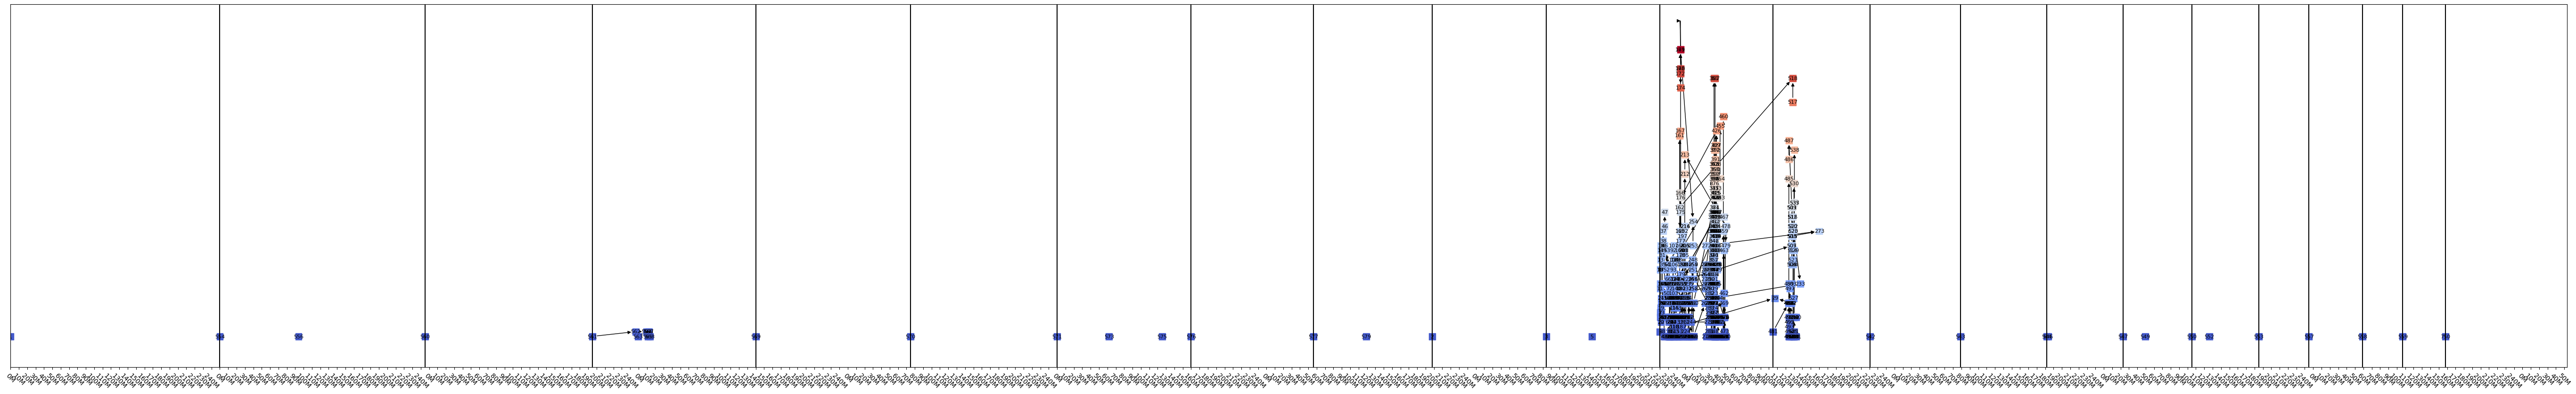

In [30]:
draw_network_colors(_graph,jsonfile)

/var/folders/1w/smv5xnxd6lb_7klgt1pwwgpw7l6lcq/T/ipykernel_35249/3349054182.py:55: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



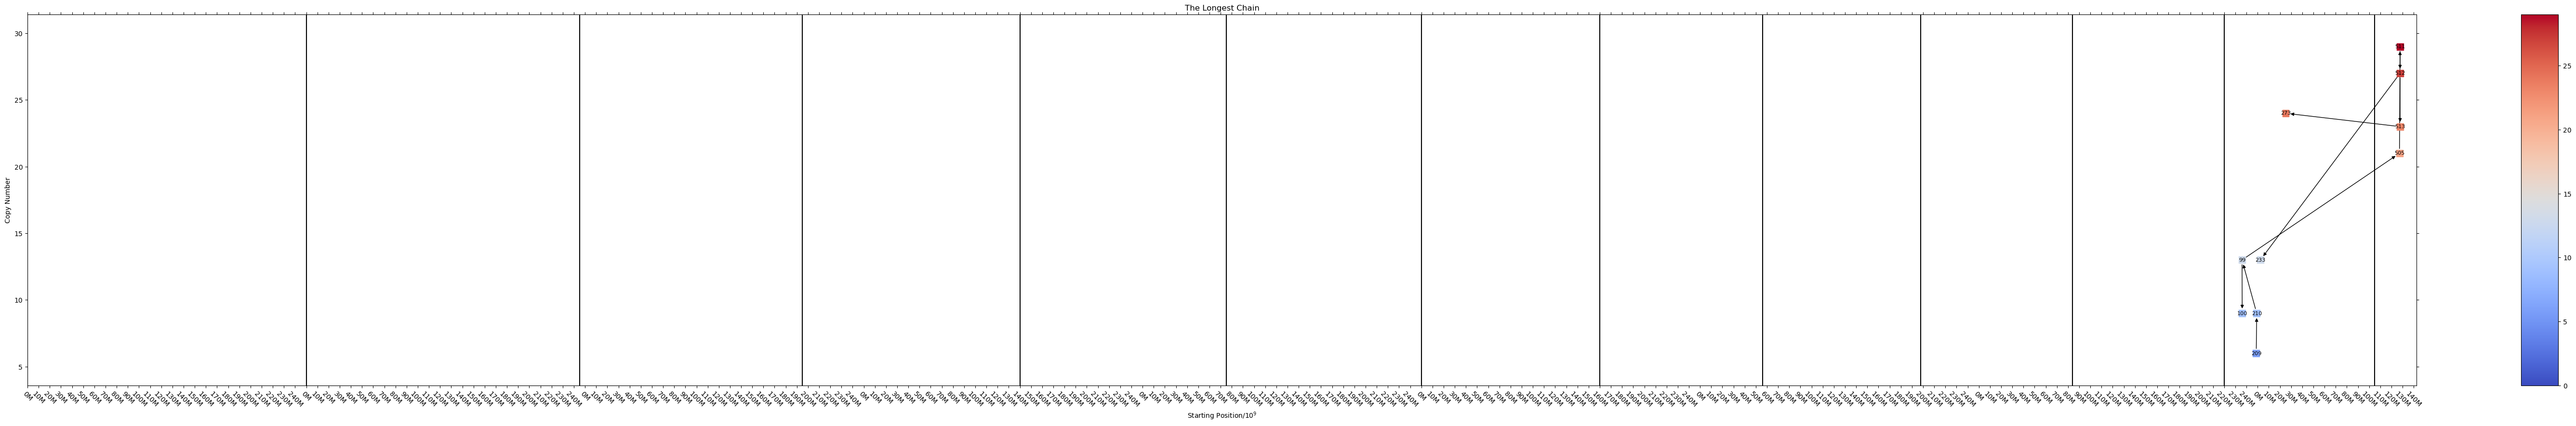

In [ ]:
draw_network_colors(longest_graph,jsonfile)

## SIMPLE CYCLES

[[169], [344]]


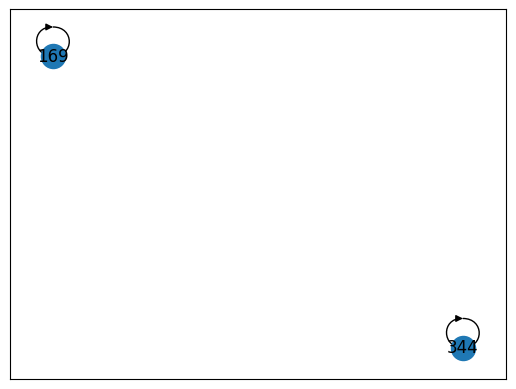

In [169]:
_graph_cycles = find_simple_cycles(jsonfile,_graph,df)
nx.draw_networkx(_graph_cycles)

## Dump or load data

In [213]:
# # dataset = '235884-WG01'
# dataset = 'SMF-12-12'
# ext = 'v1'
# do_sth = 1
# flag = 1 # 1=write, 0=load

# if do_sth == 1:
#     if flag == 1:
#         # ## WRITE
#         pickle.dump(df, open(f'saved_variables/dataframe_{dataset}_{ext}.txt', 'wb'))
#         pickle.dump(_graph, open(f'saved_variables/graph_{dataset}_{ext}.txt', 'wb'))
#         pickle.dump(longest_graph, open(f'saved_variables/longest_chain_{dataset}_{ext}.txt', 'wb'))
#         pickle.dump(_graph_cycles, open(f'saved_variables/simple_cycles_{dataset}_{ext}.txt', 'wb'))
#     else:
#         # LOAD
#         df = pickle.load(open(f'saved_variables/dataframe_{dataset}_{ext}.txt','rb'))
#         _graph = pickle.load(open(f'saved_variables/graph_{dataset}_{ext}.txt','rb'))
#         longest_graph = pickle.load(open(f'saved_variables/longest_chain_{dataset}_{ext}.txt','rb'))
#         _graph_cycles = pickle.load(open(f'saved_variables/simple_cycles_{dataset}_{ext}.txt','rb'))

## Check Dataframe 

In [214]:
print(print(df))

     Source   Sink  Copy_Number  Start_Point  End_Point Chromosome Title  \
0         3      4            2            1   51086203         11     3   
1         4      5            1     51086204   54534602         11     4   
2         6      7            3            1      89220         12     6   
3         7      8            7        89221     104907         12     7   
4         7    413            7        89221     104907         12     7   
..      ...    ...          ...          ...        ...        ...   ...   
823     575  loose            2    125243284  159345973          7   575   
824     576  loose            2            1  145138636          8   576   
825     577  loose            2            1   43389602          9   577   
826     579  loose            2     63049203  138394717          9   579   
827     750  loose            2            1  156040895          X   750   

         Type Strand  cid Conn_Title Conn_Type  Weight  SourceSign SinkSign  
0    inte

In [215]:
df[(df['Chromosome']=='X')]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
723,750,loose,2,1,156040895,X,750,interval,*,854,,LOOSE,2,-1,
827,750,loose,2,1,156040895,X,750,interval,*,958,,LOOSE,2,1,


In [216]:
df[(df['Source']==160)]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
183,160,161,20,23460003,23479652,12,160,interval,*,206,REF,REF,20,1,1
655,160,loose,20,23460003,23479652,12,160,interval,*,786,,LOOSE,20,-1,


In [217]:
df[(df['Source']==1530) & (df['Sink']==1531)]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign


In [218]:
df[(df['Source']==1546) & (df['Sink']==1547)]['SinkSign'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [219]:
GRAPH = _graph

tuples = []
for edge in GRAPH.edges():
    print(edge)
    print(df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0])
    tuples.append(edge[0])
    tuples.append(edge[1])

print(sorted(set(tuples)))

(6, 7)
3
(7, 413)
5
(8, 9)
6
(17, 18)
18
(20, 21)
22
(21, 18)
23
(23, 24)
26
(26, 27)
30
(28, 29)
34
(30, 31)
36
(33, 34)
40
(35, 36)
42
(36, 37)
43
(38, 39)
47
(40, 41)
49
(41, 42)
51
(43, 44)
54
(44, 45)
55
(46, 47)
57
(52, 53)
63
(53, 54)
64
(54, 55)
66
(54, 120)
67
(58, 59)
72
(59, 202)
74
(202, 203)
262
(61, 62)
76
(65, 66)
82
(67, 68)
84
(71, 72)
90
(73, 74)
92
(76, 77)
95
(80, 81)
99
(85, 86)
107
(87, 88)
109
(91, 92)
114
(92, 93)
115
(92, 95)
116
(95, 96)
119
(94, 95)
118
(96, 59)
120
(98, 99)
123
(99, 100)
124
(99, 505)
125
(505, 511)
626
(102, 103)
129
(107, 108)
135
(113, 114)
144
(114, 115)
145
(115, 116)
147
(119, 120)
153
(125, 126)
161
(127, 128)
163
(131, 132)
169
(136, 137)
174
(139, 140)
177
(143, 144)
182
(144, 308)
184
(308, 182)
389
(153, 154)
196
(155, 156)
199
(157, 158)
202
(159, 160)
205
(160, 161)
206
(161, 162)
207
(162, 163)
208
(162, 518)
209
(165, 166)
213
(168, 169)
216
(169, 169)
217
(170, 171)
219
(171, 254)
221
(173, 174)
223
(175, 176)
227
(177, 178)


## Write .json

In [220]:
%%capture cap --no-stderr

print('{')
print('  "settings": {')
print('    "y_axis": {')
print('      "title": "copy number",')
print('      "visible": true')
print('    },')
print('    "y.axis": "cn",')
print('    "description": "<h3>JaBbA<\/h3> "')
print('  },')

print('  "intervals": [')

for i,iid in enumerate(sorted(set(tuples))):
    Chromosome = df[(df['Source']==iid)]['Chromosome'].values[0]
    Start_Point = df[(df['Source']==iid)]['Start_Point'].values[0]
    End_Point = df[(df['Source']==iid)]['End_Point'].values[0]
    Copy_Number = df[(df['Source']==iid)]['Copy_Number'].values[0]
    Title = df[(df['Source']==iid)]['Title'].values[0]
    Type = df[(df['Source']==iid)]['Type'].values[0]
    Strand = df[(df['Source']==iid)]['Strand'].values[0]
    print('    {')
    print(f'      "chromosome": "{Chromosome}",')
    print(f'      "startPoint": {Start_Point},')
    print(f'      "endPoint": {End_Point},')
    print(f'      "iid": {iid},')
    print(f'      "y": {Copy_Number},')
    print(f'      "annotation": "",')
    print(f'      "title": "{Title}",')
    print(f'      "type": "{Type}",')
    print(f'      "strand": "{Strand}"')
    if i==len(sorted(set(tuples)))-1:
        print('    }')
    else:
        print('    },')

print('  ],')

print('  "connections": [')
for e,edge in enumerate(GRAPH.edges()):
    #print(df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0])
    cid = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0]
    source = edge[0]*df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['SourceSign'].values[0]
    sink = edge[1]*df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['SinkSign'].values[0]
    Conn_Title = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Conn_Title'].values[0]
    Conn_Type = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Conn_Type'].values[0]
    Weight = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Weight'].values[0]
    print('    {')
    print(f'      "cid": {cid},')
    print(f'      "source": {source},')
    print(f'      "sink": {sink},')
    print(f'      "title": "{Conn_Title}",')
    print(f'      "type": "{Conn_Type}",')
    print(f'      "weight": {Weight},')
    print(f'      "annotation": ""')
    if e==len(GRAPH.edges())-1:
        print('    }')
    else:
        print('    },')


print('  ]')
print('}')

In [221]:
with open('graph_SMF-12-12.json', 'w') as f:
    f.write(cap.stdout)

## PLOTLY TEST

In [157]:
def draw_plotly(G,title):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.values[0] == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.values[0] == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.values[0] == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.values[0])) # item() returns numbers as str
    
    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else ','.join(str(i) for i in df[df['Source']==node]['Sink'].to_list() if i!='loose')
        prev_node='None' if n==0 else ','.join(str(i) for i in df[df['Sink']==node]['Source'].to_list())
        if node_chr[n]==23:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: X<br>CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: Y<br>CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: M<br>CN: {node_y[n]}')
        else:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: {node_chr[n]}<br>CN: {node_y[n]}')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Can also be assigned later like below
    # node_trace.text = node_id
    # node_trace.marker.color = node_chr

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Number of nodes: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number"))
                    )
    fig.show()

In [141]:
15045317-15144367 == 2538045317-2538144367

True

In [163]:
def draw_plotly_domains(G,title):
    positions=nx.get_node_attributes(G,'pos')
    domains=nx.get_node_attributes(G,'domain')
    final_positions = {}
    for pos, dom in zip(positions.items(), domains.items()):
        label, (x, y) = pos # label is node
        _, d = dom
        idx_dom = int(d_to_idx[d])
        final_positions[label] = [x + domain_starts[idx_dom-1], y]

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = final_positions[edge[0]][0],final_positions[edge[0]][1]
        x1, y1 = final_positions[edge[1]][0],final_positions[edge[1]][1]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        #x, y = G.nodes[node]['pos']
        x, y = final_positions[node][0],final_positions[node][1]
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.values[0] == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.values[0] == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.values[0] == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.values[0])) # item() returns numbers as str
    

    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else ','.join(str(i) for i in df[df['Source']==node]['Sink'].to_list() if i!='loose')
        prev_node='None' if n==0 else ','.join(str(i) for i in df[df['Sink']==node]['Source'].to_list())
        if node_chr[n]==23:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: X<br>CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: Y<br>CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: M<br>CN: {node_y[n]}')
        else:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: {node_chr[n]}<br>CN: {node_y[n]}')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Number of nodes: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number")
                    )
                    )
    fig.show()

In [48]:
longest_graph.edges()

OutEdgeView([(197, 198), (198, 199), (198, 819), (199, 204), (204, 205), (205, 50), (50, 212), (212, 213), (213, 214), (214, 406), (406, 214)])

In [54]:
print(longest_graph.nodes[197])
print(longest_graph.nodes[197]['domain'])

{'pos': (15045317, 6), 'domain': '17'}
17


In [119]:
print(_graph.nodes[866])
print(_graph.nodes[866]['domain'])

{'pos': (139524307, 7), 'domain': 'X'}
X


In [167]:
#draw_plotly(longest_graph,'Network graph of the longest chain')

In [164]:
draw_plotly_domains(longest_graph,'Network graph of the longest chain')

In [166]:
#draw_plotly(_graph,'Network graph of all the paths')

In [165]:
draw_plotly_domains(_graph,'Network graph of all the paths')

In [170]:
draw_plotly_domains(_graph_cycles,'Network graph of the circular paths')

KeyError: 169

1534 22 20
--- (1534, (22, 20)) -- (1534, 0)
0
[22, 20]
945 32 10
--- (945, (32, 10)) -- (945, 1)
100
[132, 10]
946 40 9
--- (946, (40, 9)) -- (946, 2)
200
[240, 9]
__PLOT__
XX (-0.8900000000000023, 262.89)
tick_range [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]


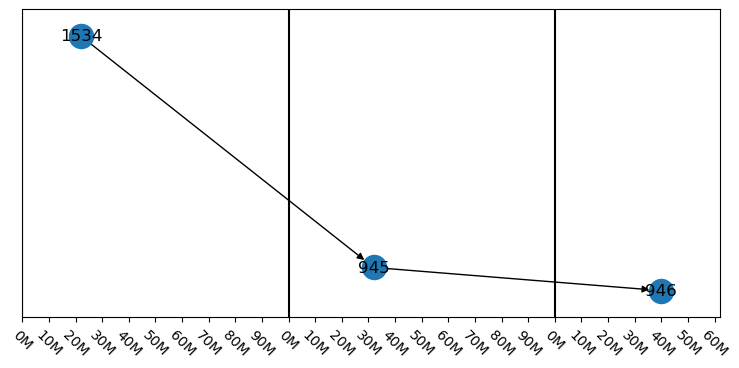

In [44]:
G33 = nx.DiGraph()
G33.add_node(1534, pos=(22, 20), domain=0)
G33.add_node(945, pos=(32, 10), domain=1)
G33.add_node(946, pos=(40, 9), domain=2)
G33.add_edge(1534, 945)
G33.add_edge(945, 946)

d_starts = [0, 100, 200]
# d_starts = {'1': 0, '2': 100, 'X': 200}

positions = nx.get_node_attributes(G33, "pos")
domains = nx.get_node_attributes(G33, "domain")

final_positions = {}

for pos, dom in zip(positions.items(), domains.items()):
    label, (x, y) = pos
    print(label,x,y)
    print("---",pos,"--",dom)
    _, d = dom
    print(d_starts[d])
    final_positions[label] = [x + d_starts[d], y]
    print(final_positions[label])


print("__PLOT__")
fig, ax = plt.subplots(figsize=(9,4))
nx.draw_networkx(G33, final_positions, ax=ax)

# Works properly if d_starts values are modulo of the tick range step (here 10M)
print("XX",ax.get_xlim())
max_xlim = int(ax.get_xlim()[1])
tick_range = range(0, max_xlim, 10)
print("tick_range",list(tick_range))
labels = [f"{(i % d_starts[1])  :.0f}M" for i in tick_range]

ax.set_xlim(0, max_xlim)
ax.set_xticks(tick_range, labels , rotation=-45)
ax.tick_params(bottom=True, labelbottom=True)

for ypos in d_starts:
    ax.axvline(ypos, c="k")